In [205]:
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
import pickle
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (8,6)

In [206]:
%run ../code/data_proc.py
test_data = read_cdph_test()

In [207]:
test_data = test_data.groupby(['lab_result_date','county','FIPS']).sum()

In [208]:
test_data = test_data.reset_index()

In [209]:
test_data['county'] = test_data['county'].str.title()

In [210]:
test_data['pos_rate'] = test_data.eval('pos_results / (pos_results + neg_results)')

In [211]:
test_data['lab_result_date'] = pd.PeriodIndex(test_data['lab_result_date'], freq='D')

In [212]:
hdt_data = pd.read_csv('../data/DeloitteWeekly_v3_LJS_04182021.csv')

In [213]:
with open('../data/davis_CBG.pickle','rb') as file:
    Davis_CBG = pickle.load(file)

In [214]:
geo_nas = hdt_data['CensusGEOID'].isna()
hdt_data.loc[~geo_nas,'CensusGEOID'] = hdt_data.loc[~geo_nas,'CensusGEOID'].astype(int).astype(str).str.zfill(15)
hdt_data['CollectionDateTime'] = pd.to_datetime(hdt_data['CollectionDateTime'])

hdt_data['age_range'] = pd.cut(hdt_data['age'],
       [0,18,25,35,45,55,65,75,85,200],
       right = False,
       labels=['0-17','18-24','25-34','35-44','45-54','55-64','65-74','75-84','85+'])

hdt_data.loc[~geo_nas,'CBG'] = hdt_data.loc[~geo_nas,'CensusGEOID'].str[:-3]

In [215]:
hdt_data.loc[geo_nas,'CBG'] = 'NA'
hdt_data['positive'] = hdt_data['Result'] == 'Detected'
hdt_data['negative'] = hdt_data['Result'] == 'Not Detected'

In [216]:
hdt_data['Date'] = pd.PeriodIndex(hdt_data['CollectionDateTime'], freq='D')

In [217]:
hdt_daily = hdt_data.groupby('Date').sum()[['positive','negative']]

In [218]:
davis_data = hdt_data[hdt_data['CBG'].isin(Davis_CBG)]

In [219]:
yolo_hdt_data = hdt_data[hdt_data['County'] == 'Yolo']

In [220]:
davis_daily = davis_data.groupby('Date').sum()[['positive','negative']]

In [221]:
hdt_daily = hdt_daily.join(hdt_daily.rolling('7D').mean(),rsuffix='_7dav')
hdt_daily['pos_rate'] = hdt_daily.eval('positive / (positive + negative)')
hdt_daily['pos_rate_7dav'] = hdt_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [222]:
davis_daily = davis_daily.join(davis_daily.rolling('7D').mean(),rsuffix='_7dav')
davis_daily['pos_rate'] = davis_daily.eval('positive / (positive + negative)')
davis_daily['pos_rate_7dav'] = davis_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [223]:
ca_daily = test_data.groupby('lab_result_date').sum().rename(columns={'pos_results':'positive', 'neg_results':'negative'})

In [224]:
ca_daily = ca_daily.join(ca_daily.rolling('7D').mean(),rsuffix='_7dav')
ca_daily['pos_rate'] = ca_daily.eval('positive / (positive + negative)')
ca_daily['pos_rate_7dav'] = ca_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [225]:
yolo_daily = test_data.query('FIPS=="06113"')

In [226]:
yolo_daily = yolo_daily.groupby('lab_result_date').sum().rename(columns={'pos_results':'positive', 'neg_results':'negative'})

In [227]:
yolo_daily = yolo_daily.join(yolo_daily.rolling('7D').mean(),rsuffix='_7dav')
yolo_daily['pos_rate'] = yolo_daily.eval('positive / (positive + negative)')
yolo_daily['pos_rate_7dav'] = yolo_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [228]:
yolo_daily = yolo_daily.reset_index().rename(columns={'lab_result_date':'Date'})
ca_daily = ca_daily.reset_index().rename(columns={'lab_result_date':'Date'})

In [229]:
hdt_daily.reset_index(inplace=True)
davis_daily.reset_index(inplace=True)

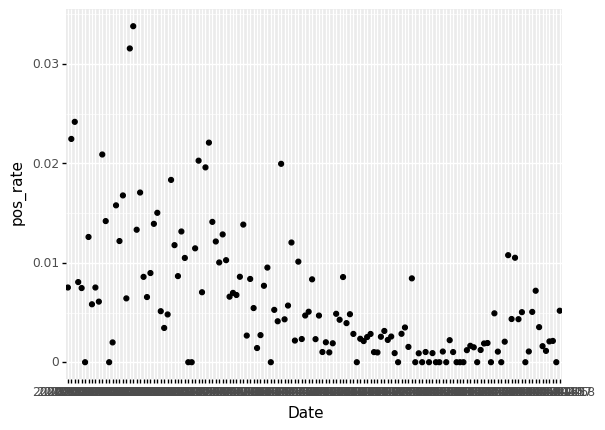

<ggplot: (8781706557194)>

In [230]:
p9.ggplot(davis_daily, p9.aes(x='Date',y='pos_rate')) + p9.geom_point()

Text(0, 0.5, 'Pos PPT')

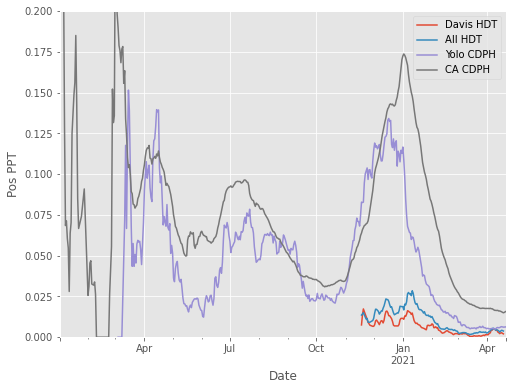

In [231]:
ax = davis_daily.plot('Date','pos_rate_7dav',label='Davis HDT')
hdt_daily.plot('Date','pos_rate_7dav', ax=ax, label='All HDT')
yolo_daily.plot('Date','pos_rate_7dav', ax=ax, label='Yolo CDPH')
ca_daily.plot('Date','pos_rate_7dav', ax=ax, label='CA CDPH')
plt.ylim([0,.2])
plt.ylabel('Pos PPT')

In [232]:
yolo_daily['total_7dav'] = yolo_daily.eval('positive_7dav + negative_7dav')
yolo_daily['total'] = yolo_daily.eval('positive + negative')

<AxesSubplot:xlabel='Date'>

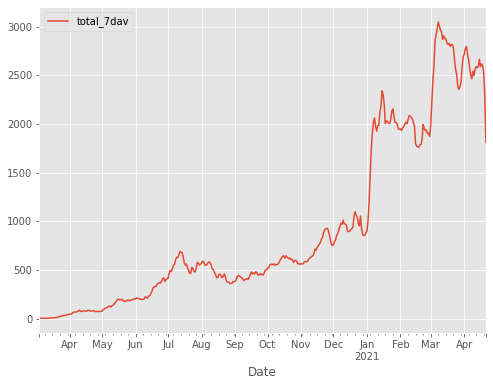

In [233]:
yolo_daily.plot('Date','total_7dav')

In [234]:
yolo_hdt_daily = yolo_hdt_data.groupby('Date').sum()[['positive','negative']]
yolo_hdt_daily = yolo_hdt_daily.join(yolo_hdt_daily.rolling('7D').mean(),rsuffix='_7dav')

In [235]:
yolo_hdt_daily['total'] = yolo_hdt_daily.eval('positive + negative')
yolo_hdt_daily['total_7dav'] = yolo_hdt_daily.eval('positive_7dav + negative_7dav')

In [236]:
yolo_hdt_daily.reset_index(inplace=True)

/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fca5e45abe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fca5e469940> has a label of '_nolegend_' which cannot be automatically added to the legend.


Text(0, 0.5, 'Total tests')

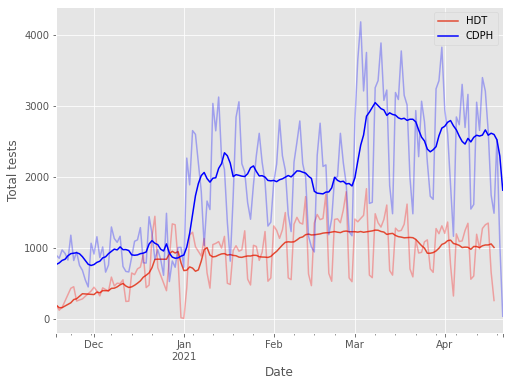

In [237]:
ax = yolo_hdt_daily.plot('Date','total_7dav',label='HDT')
yolo_hdt_daily.plot('Date','total',ax=ax,color='r',alpha=.3,label="_nolegend_")
yolo_daily.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total_7dav', ax=ax,label='CDPH',color='b')
yolo_daily.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total', ax=ax, label="_nolegend_",color='b',alpha=.3)
plt.ylabel('Total tests')

In [238]:
yolo_corr = yolo_daily[['Date','positive','negative']].copy()

In [239]:
yolo_corr = yolo_corr.set_index('Date')

In [240]:
yolo_hdt_daily = yolo_hdt_daily.set_index('Date')

In [241]:
yolo_hdt_daily

,positive,negative,positive_7dav,negative_7dav,total,total_7dav
Date,,,,,,
2020-11-18,3,185,3.000000,185.000000,188,188.000000
2020-11-19,2,115,2.500000,150.000000,117,152.500000
2020-11-20,3,154,2.666667,151.333333,157,154.000000
2020-11-23,3,424,2.750000,219.500000,427,222.250000
2020-11-24,4,445,3.000000,264.600000,449,267.600000
...,...,...,...,...,...,...
2021-04-14,1,1271,2.857143,1024.285714,1272,1027.142857
2021-04-15,4,1320,3.428571,1035.285714,1324,1038.714286
2021-04-16,6,1342,4.000000,1035.142857,1348,1039.142857


In [242]:
corr_ser = yolo_corr['negative'].copy().add(yolo_hdt_daily.loc[:'2021-1-1','negative'].copy(), fill_value=0)

In [243]:
yolo_corr.index

PeriodIndex(['2020-03-04', '2020-03-05', '2020-03-07', '2020-03-08',
             '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14',
             '2020-03-15', '2020-03-16',
             ...
             '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15',
             '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19',
             '2021-04-20', '2021-04-21'],
            dtype='period[D]', name='Date', length=411, freq='D')

In [244]:
yolo_hdt_daily.index

PeriodIndex(['2020-11-18', '2020-11-19', '2020-11-20', '2020-11-23',
             '2020-11-24', '2020-11-25', '2020-11-27', '2020-11-30',
             '2020-12-01', '2020-12-02',
             ...
             '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12',
             '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
             '2021-04-17', '2021-04-18'],
            dtype='period[D]', name='Date', length=144, freq='D')

In [245]:
yolo_hdt_daily.loc[:'2021-1-1','negative']

Date
2020-11-18     185
2020-11-19     115
2020-11-20     154
2020-11-23     424
2020-11-24     445
2020-11-25     247
2020-11-27     273
2020-11-30     384
2020-12-01     435
2020-12-02     383
2020-12-03     311
2020-12-04     426
2020-12-06     382
2020-12-07     583
2020-12-08     453
2020-12-09     493
2020-12-10     485
2020-12-11     536
2020-12-12     232
2020-12-13     237
2020-12-14     631
2020-12-15     609
2020-12-16     690
2020-12-17     718
2020-12-18     899
2020-12-19     430
2020-12-20     460
2020-12-21    1147
2020-12-22    1433
2020-12-23     713
2020-12-26     384
2020-12-27     836
2020-12-28    1319
2020-12-29    1300
2020-12-30     808
2020-12-31      11
2021-01-01       2
Freq: D, Name: negative, dtype: int64

In [246]:
yolo_corr['negative'] = yolo_corr['negative'].copy()\
    .add(yolo_hdt_daily.loc[:'2021-1-1','negative'], fill_value=0)

In [247]:
yolo_corr['negative'].copy()\
    .add(yolo_hdt_daily.loc[:'2021-1-1','negative'], fill_value=0)

Date
2020-03-04       3.0
2020-03-05       4.0
2020-03-07       1.0
2020-03-08       4.0
2020-03-11       4.0
               ...  
2021-04-17    1727.0
2021-04-18    1473.0
2021-04-19    2516.0
2021-04-20    1045.0
2021-04-21      31.0
Freq: D, Name: negative, Length: 411, dtype: float64

In [248]:
yolo_corr = yolo_corr.join(yolo_corr.rolling('7D').mean(),rsuffix='_7dav')
yolo_corr['pos_rate'] = yolo_corr.eval('positive / (positive + negative)')
yolo_corr['pos_rate_7dav'] = yolo_corr.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [249]:
yolo_corr

,positive,negative,positive_7dav,negative_7dav,pos_rate,pos_rate_7dav
Date,,,,,,
2020-03-04,0,3.0,0.000000,3.000000,0.000000,0.000000
2020-03-05,0,4.0,0.000000,3.500000,0.000000,0.000000
2020-03-07,0,1.0,0.000000,2.666667,0.000000,0.000000
2020-03-08,0,4.0,0.000000,3.000000,0.000000,0.000000
2020-03-11,1,4.0,0.250000,3.250000,0.200000,0.071429
...,...,...,...,...,...,...
2021-04-17,17,1727.0,16.571429,2600.714286,0.009748,0.006332
2021-04-18,14,1473.0,16.000000,2583.571429,0.009415,0.006155
2021-04-19,13,2516.0,15.714286,2508.714286,0.005140,0.006225


In [250]:
yolo_corr['total'] = yolo_corr.eval('positive + negative')
yolo_corr['total_7dav'] = yolo_corr.eval('positive_7dav + negative_7dav')

In [251]:
yolo_corr.reset_index(inplace=True)
yolo_hdt_daily.reset_index(inplace=True)

/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fca686e19a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fca684cff70> has a label of '_nolegend_' which cannot be automatically added to the legend.
/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fca684e3a90> has a label of '_nolegend_' which cannot be automatically added to the legend.


Text(0, 0.5, 'Total tests')

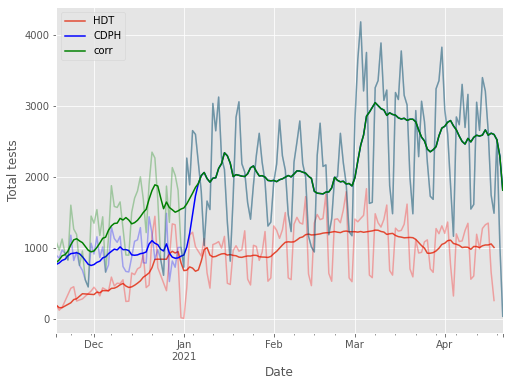

In [252]:
ax = yolo_hdt_daily.plot('Date','total_7dav',label='HDT')
yolo_hdt_daily.plot('Date','total',ax=ax,color='r',alpha=.3,label="_nolegend_")
yolo_daily.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total_7dav', ax=ax,label='CDPH',color='b')
yolo_daily.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total', ax=ax, label="_nolegend_",color='b',alpha=.3)
yolo_corr.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total_7dav', ax=ax,label='corr',color='g')
yolo_corr.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total', ax=ax, label="_nolegend_",color='g',alpha=.3)
plt.ylabel('Total tests')

Text(0, 0.5, 'Pos PPT')

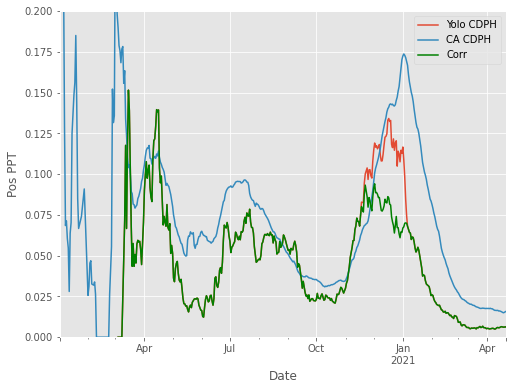

In [257]:
ax = yolo_daily.plot('Date','pos_rate_7dav', label='Yolo CDPH')
ca_daily.plot('Date','pos_rate_7dav', ax=ax, label='CA CDPH')
yolo_corr.plot('Date','pos_rate_7dav', ax=ax, label='Corr', color='g')
plt.ylim([0,.2])
plt.ylabel('Pos PPT')